In [149]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import re

### Import Impedance Data

In [191]:
impedance_filename = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk analysis\mutual_inductance_impedance_matrix_data.txt'
# impedance_filename = r'C:\Users\mattm\OneDrive\Desktop\Research\Projects\Triangle Lattice\Jupyter Notebooks\crosstalk analysis\mutual_inductance_impedance_matrix_data_switch_c34.txt'

frequencies = []
# impedances = []

# regex to find matrix element index
matrix_element_regex = re.compile(r"Im\(Z\((?P<i>\d+), ?(?P<j>\d).*")

# determine number of data points
counter = 0
with open(impedance_filename, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    for row in reader:
        counter += 1
        
        
number_of_ports = 9

# row is the index of the loop
# column is the index of the fluxline
impedance_crosstalk_matrix = np.zeros((counter-1, number_of_ports, number_of_ports), dtype='complex')

with open(impedance_filename, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t', quotechar='|')
    
    
    i = 0
    for row in reader:
        if i == 0:
            headers = row[1:]
            matrix_element_order = []
            
            for header in headers:
            
                match = matrix_element_regex.search(header)
                groupdict = match.groupdict()
                matrix_element_order.append((int(groupdict['i'])-1, int(groupdict['j'])-1))
            
        elif i > 0:
            frequency = float(row[0])
            frequencies.append(frequency)
            
            for j, value in enumerate(row[1:]):
                
                fluxline_index, loop_index = matrix_element_order[j]
                                
                impedance_crosstalk_matrix[i-1, loop_index, fluxline_index - number_of_ports] = float(value)
                

        i += 1
        
frequencies = np.array(frequencies)


In [192]:
mutual_inductance_crosstalk_matrix = np.zeros((number_of_ports, number_of_ports), dtype='complex')

# need frequency in angular units
frequency_difference = (frequencies[-1] - frequencies[0]) * 2 * np.pi

for i in range(number_of_ports):
    for j in range(number_of_ports):
        if i == 0:
            if j ==0:
                print(frequency_difference)
                print(impedance_crosstalk_matrix[-1, i, j] - impedance_crosstalk_matrix[0, i, j])
        mutual_inductance_crosstalk_matrix[i, j] = (impedance_crosstalk_matrix[-1, i, j] - impedance_crosstalk_matrix[0, i, j])/frequency_difference
        
# keep real part
mutual_inductance_crosstalk_matrix = mutual_inductance_crosstalk_matrix.real

# convert to pico Henry
mutual_inductance_crosstalk_matrix *= 1e3


0.6283185307179586
(0.000717199+0j)


In [193]:
print(mutual_inductance_crosstalk_matrix[0,0])
print(mutual_inductance_crosstalk_matrix[4,0])

1.1414576603056423
0.16555615490305137


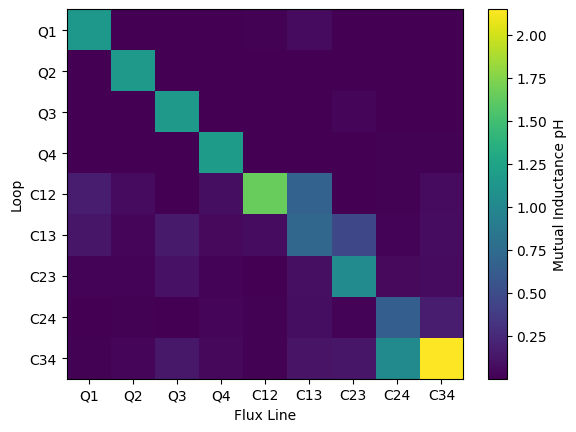

In [194]:
plt.imshow(np.abs(mutual_inductance_crosstalk_matrix), interpolation='none', aspect='auto')

plt.colorbar(label='Mutual Inductance pH')

plt.xlabel('Flux Line')
plt.ylabel('Loop')

labels = ['Q1', 'Q2', 'Q3', 'Q4', 'C12', 'C13', 'C23', 'C24', 'C34']

plt.xticks(range(number_of_ports), labels)
plt.yticks(range(number_of_ports), labels)

plt.show()

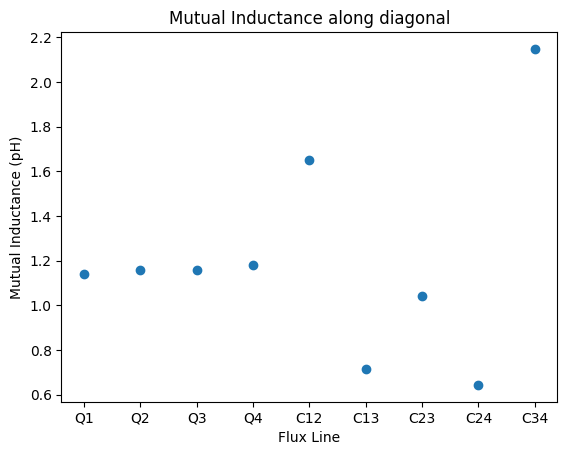

[1.14145766 1.15824055 1.159361   1.17974556 1.65056408 0.71284385
 1.03978312 0.64318969 2.14800286]


In [196]:
plt.plot(np.abs(np.diag(mutual_inductance_crosstalk_matrix)), linestyle='', marker='o')

plt.xlabel('Flux Line')
plt.ylabel('Mutual Inductance (pH)')

labels = ['Q1', 'Q2', 'Q3', 'Q4', 'C12', 'C13', 'C23', 'C24', 'C34']
plt.xticks(range(number_of_ports), labels)

plt.title('Mutual Inductance along diagonal')
plt.show()

print(np.abs(np.diag(mutual_inductance_crosstalk_matrix)))


In [190]:
print(mutual_inductance_crosstalk_matrix[0,1]/mutual_inductance_crosstalk_matrix[0,0])

-0.0017269445731737955


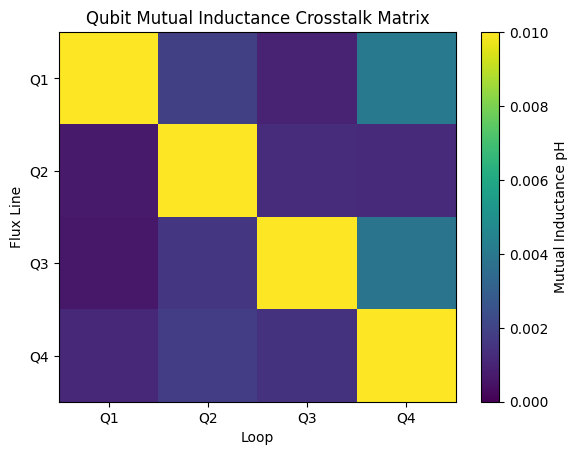

In [174]:
# look at qubit subspace

qubit_crosstalk_matrix = np.abs(mutual_inductance_crosstalk_matrix[:4,:4])
qubit_crosstalk_matrix_normalized = np.copy(qubit_crosstalk_matrix)

# for i in range(4):
#     qubit_crosstalk_matrix_normalized[:,i] /= np.max(qubit_crosstalk_matrix_normalized[:,i])

plt.imshow(np.abs(qubit_crosstalk_matrix_normalized), interpolation='none', aspect='auto', vmin=0, vmax=0.01)

plt.colorbar(label='Mutual Inductance pH')

plt.xlabel('Loop')
plt.ylabel('Flux Line')

labels = ['Q1', 'Q2', 'Q3', 'Q4']

plt.title('Qubit Mutual Inductance Crosstalk Matrix')

plt.xticks(range(4), labels)
plt.yticks(range(4), labels)

plt.show()

# Crosstalk Matrix

We have mutual inductance matrix organized with fluxlines as the columns and loops as the rows. The order is \[Q1, Q2, Q3, Q4, C12, C13, C23, C24, C34\]

$$
\mathbf{M} = \begin{bmatrix}
L_1F_1 & L_1F_2 & \cdots & L_1F_N\\
L_2F_1 & L_2F_2 & \cdots & L_2F_N\\
\vdots & \vdots & & \vdots\\
L_NF_1 & L_NF_2 & \cdots & L_NF_N\\
\end{bmatrix}
$$

Consider a column vector of currents
$$
I = \begin{bmatrix}
I_1\\
I_2\\
\vdots\\
I_N
\end{bmatrix}
$$

The magnetic flux on loop $i$ is given by 
$$
\Phi_i = I_1 * (F_1L_i) + I_2 * (F_2L_i) + \cdots + I_N * (F_NL_i)
$$

So the magnetic flux vector $\Phi$ is given by
$$\Phi = \mathbf{M}I$$

If we apply a voltage vector $
V = \begin{bmatrix}
V_1\\
V_2\\
\vdots\\
V_N
\end{bmatrix}
$ to our $N$ flux lines, then we are applying a magnetic flux vector $\Phi = \mathbf{M}\mathbf{R}^{-1}V$ on each loop, where we define the $N \times N$ diagonal resistance matrix by $\mathbf{R}_{ii} = R_i$ for resistance $R_i$ on fluxline $i$.

Then, if we want to apply a magnetic flux $\Phi$, then we have to apply a voltage vector such that $V = \mathbf{R}\mathbf{M}^{-1}\Phi$

### Use periodicity to estimate resistances

In [178]:
# C24: period = 2.9
# C34: period= 1.84

# 'Q1', 'Q2', 'Q3', 'Q4', 'C12', 'C13', 'C23', 'C24', 'C34'
# in units of V/flux quantum = V/()
periods = np.array([2, 2, 2, 2, 2, 2, 2, 2.9, 1.84])

# flux quantum
Phi_0 = 2.067833848e-15 # Wb

# resistance is R (Ohm) = V (V) / I (A)
# V (V) = period
# I (A) = Phi (Wb) / L (H)
# Phi (Wb) = 1 * Phi_0 (Wb)
# R (Ohm) = V (V) * L (H) / Phi_0 (Wb) 

diagonal_mutual_inductances = np.diag(mutual_inductance_crosstalk_matrix)
diagonal_mutual_inductances_Henry = np.diag(mutual_inductance_crosstalk_matrix) * 1e-12 # convert from pH to H

R = periods * diagonal_mutual_inductances_Henry / Phi_0
print(R)

[ 1104.01293741  1120.24527519  1121.32897039  1141.04483405
 -1596.41847957   689.45950368 -1005.67375611  -902.03093359
 -1911.33599219]


In [157]:
inverse_mutual_inductance_matrix = np.linalg.inv(mutual_inductance_crosstalk_matrix)

### Determine effect of applying voltage on each channel

0.0010773363780334398
Q1: -0.003
Q2: 0.003
Q3: -0.006
Q4: 0.013
C12: 0.065
C13: 0.068
C23: -0.062
C24: -0.166
C34: -2.148


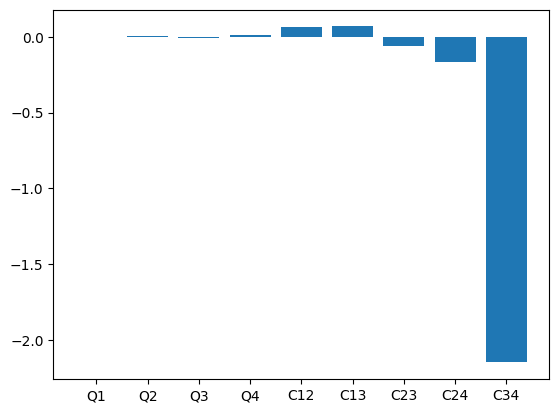

In [169]:
V_Q1 = 0
V_Q2 = 0
V_Q3 = 0
V_Q4 = 0
V_C12 = 0
V_C13 = 0
V_C23 = 0
V_C24 = 0
V_C34 = 1

test_voltage_vector = np.array([V_Q1, V_Q2, V_Q3, V_Q4, V_C12, V_C13, V_C23, V_C24, V_C34])
test_resistance_matrix = np.eye(len(test_voltage_vector))
inverse_resistance_matrix = np.linalg.inv(test_resistance_matrix)

test_Phi = mutual_inductance_crosstalk_matrix @ inverse_resistance_matrix @ test_voltage_vector
test_Phi_normalized = np.abs(test_Phi)/np.sum(np.abs(test_Phi))

print(test_Phi_normalized[0])

labels = ['Q1', 'Q2', 'Q3', 'Q4', 'C12', 'C13', 'C23', 'C24', 'C34']
plt.xticks(range(number_of_ports), labels=labels)

# plt.bar(range(len(test_voltage_vector)), test_Phi_normalized)
plt.bar(range(len(test_voltage_vector)), test_Phi)

for i in range(len(labels)):
    print(f'{labels[i]}: {round(test_Phi[i], 3)}')
